## Imports

In [1]:
import numpy as np
import os
import matplotlib.image as mpimg
import json
import src.image_features as imgfeats
from sklearn.preprocessing import normalize
import operator
from src.ir_evaluation import Evaluator
import copy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import time

## Implémentations des fonctions du code

In [12]:
def to_dictionnary(mot, data):
    '''
    fonction pour transformer les datasets en dictionnaires où key correspond à l'id
    et value aux données
    :param mot:
    :param data: DataFrame importé d'un fichier Json
    :return: Le dataset sous format dictionnaire
    '''
    files = {}
    for d in data[mot]:
        files[d["id"]] = d["file"]
    return files

def mAP(queries_dic, groundtruth, sdm, norm, hist=False):
    '''
    Fonction permettant de calculer le mAP en appliquant la méthode moteur_de_recherche_hist() pour la rechere par histogramme
    et recherche() pour les autres méthodes
    :param queries_dic: Dictionnaire contenant les requêtes à tester
    :param groundtruth: Vérité de terrain des requêtes queries_dic
    :param sdm: Dictionnaire contenant les éléments à comparer pour la recherche (histogrammes, sac de mots, résidus)
    :param norm: norme à appliquer pour le calcul des distances
    :param hist: Booléen, fixer à True pour la recherche par histogramme, False pour les autres
    :return: score mAP de la méthode en testant avec l'ensemble des requêtes de queries_dic
    '''
    tab = []
    for q in queries_dic.items():
        dic = {}
        if hist:
            res = moteur_de_recherche_hist(q[0], sdm, norm)
        else:
            res = recherche(sdm, norm, q[0])
        dic["relevant"] = res
        dic["id"] = q[0]
        tab.append(dic)
    gr = {"groundtruh": tab}
    e = Evaluator(gr, groundtruth)
    return e.evaluate_map()


def recall_precision(queries_dic, groundtruth, sdm, norm, hist=False):
    '''
    Fonction permettant de calculer le Rappel et la précision en appliquant la méthode moteur_de_recherche_hist() pour la rechere par histogramme
    et recherche() pour les autres méthodes
    :param queries_dic: Dictionnaire contenant les requêtes à tester
    :param groundtruth: Vérité de terrain des requêtes queries_dic
    :param sdm: Dictionnaire contenant les éléments à comparer pour la recherche (histogrammes, sac de mots, résidus)
    :param norm: norme à appliquer pour le calcul des distances
    :param hist: Booléen, fixer à True pour la recherche par histogramme, False pour les autres
    :return: tuple de lists:{[recall],[precision]} rappel et précision obtenu en testant avec l'ensemble des requêtes de queries_dic
    '''
    tab = []
    for q in queries_dic.items():
        dic = {}
        if hist:
            res = moteur_de_recherche_hist( q[0], sdm, norm)
        else:
            res = recherche(sdm, norm, q[0])
        dic["relevant"] = res
        dic["id"] = q[0]
        tab.append(dic)
    gr = {"groundtruh": tab}
    e = Evaluator(gr, groundtruth)
    rec_pres = e.evaluate_pr_points()
    recall = [i[0] for i in rec_pres]
    precision = [i[1] for i in rec_pres]

    return recall, precision

def histogramms(files,bin_size):
    '''
    Fonction permetant de transformer les données du dictionnaire files en histogrammes
    :param files: Dictionnaire contenant les données des images à convertir
    :param bin_size: bins_per_channel.
    :return: retourne un dictionnaire conteant les histogrammes du dataset files ou chaque histogramme est de dimensions bin_size**3
    '''
    histo = {}
    for l in files.items():
        impath = "ukbench-subset/" + l[1]
        img = mpimg.imread(impath)
        histo[l[0]] = imgfeats.color_histogram(img, bin_size)
    return histo

def moteur_de_recherche_hist( query_id, data_hist, norm):
    '''
    fonction permettant d'appliquer la recherche de plus proches voisins d'une
    image rêquete  repérée  par query_id en utilisant la technique des histogrammes
    :param query_id: identifiant de la requête
    :param data_hist: dictionnaire contenant les histogrammes du dataset
    :param norm: norm à utiliser pour le calcul de distance
    :return: dictionnaire contenant les images du dataset triées de la plus proche à la requête a la plus loingtaine
    '''
    n = 2
    if norm == "L1":
        n = 1

    q_hist=data_hist[query_id]
    dists = {}
    for d in data_hist.items():
        norme = np.linalg.norm(q_hist - d[1], n)
        dists[d[0]] = norme

    return dict(sorted(dists.items(), key=lambda item: item[1])).keys()

def get_descritpeurs(data_dic):
    '''
    fonction permettant d'obtenir les descripteurs d'un dataset
    :param data_dic: Dictionnaire contenant les éléments du dataset
    :return: dictionnaire contenant les descripteurs du dataset
    '''
    descripteurs = {}
    for l in data_dic.items():
        impath = "ukbench-subset/" + l[1]
        impath = impath.replace(".jpg", ".key")
        descripteurs[l[0]] = imgfeats.get_keypoints_and_descriptors(impath)[1]
    return descripteurs

def vocab_to_dic(vocab):
    '''
    fonction permettant de convertir le fichier vocab contenant les mots de vocabulaires en dictionnaire
    :param vocab: fichier contenant le vocabulaire importé en .npy
    :return:dictionnaire contenant le vocabulaire
    '''
    voc_dic = {}
    for i, v in enumerate(vocab):
        voc_dic[i] = v
    return voc_dic

def sac_de_mots(descripteur, vocab_dic,norm):
    '''
    fonction permettant d'obtenir le sac de mot d'une images repérée par ces descripteurs dans la liste descripteur
    :param descripteur: liste contenant les descripteurs d'une image
    :param vocab_dic: Dictionnaire de vocabulaire contenant les mots de vocabulaire
    :param norm: norme à utiliser pour calculer la distance entre le mot et le descritpeur
    :return: liste de la taille du vocabulaire contenant le compte de chaque mots de vocabulaire de l'image repérée par ses descripteurs
    '''
    resultat = [0 for x in range(len(vocab_dic))]
    for mot in descripteur:
        w = np.inf
        for i, v in enumerate(vocab_dic.items()):

            if np.linalg.norm(mot - v[1], 2) < w:
                w = np.linalg.norm(mot - v[1], 2)
                res = v[0]

        resultat[res] += 1
    return resultat

def all_sac_de_mots(vocab_dic, descripteurs,norm):
    '''
    fonction qui applique la fonction sac_de_mots pour l'ensembemble des images du dataset
    :param vocab_dic: Dictionnaire de vocabulaire contenant les mots de vocabulaire
    :param descripteurs: Dictionnaire contenant les descripteurs de chaque image du dataset
    :param norm: norm à appliquer pour le calcul des distances
    :return: Dictionnaire contenant les résultats de la fonction sac_de_mots
    '''
    sdm = {}
    for d in descripteurs.items():
        sdm[d[0]] = sac_de_mots(d[1], vocab_dic,norm)
    return sdm

def sqrt_tf(sdm):
    sdm_pondere = {}
    for s in copy.deepcopy(sdm).items():
        sdm_pondere[s[0]] = np.sqrt(s[1])
    return sdm_pondere

def idf(sdm,vocab_dic):
    df = [0 for x in range(len(vocab_dic))]
    sdm_pondere = {}
    ponderation = []
    for i in range(len(vocab_dic)):
        for s in sdm.values():
            if s[i] > 0:
                df[i] += 1

    for p in df:
        ponderation.append(np.log(len(sdm) / p))
    for s in copy.deepcopy(sdm).items():
        sdm_pondere[s[0]] = [ponderation * j for ponderation, j in zip(ponderation, s[1])]
    return sdm_pondere

def ponderation(sdm, vocab_dic):
    """
    fonction permettant d'appliquer la pondération sqrt(tf).idf des valeurs du sac de mots
    :param sdm: sac de mots non pondéré
    :param vocab_dic: Dictionnaire de vocabulaire contenant les mots de vocabulaire
    REMARQUE : pour garder une trace du sac de mots sans pondération,(utile par la suite) le résultat
    de cette fonction est stocké dans une copie du sac de mots  en utilisant la fonction copy.deepcopy()
    :return: sac de mots avec valeurs pondérées
    """
    return(idf(sqrt_tf(sdm),vocab_dic))
def normalisation(sdm, norm):
    """
    fonction permettant de normaliset les valeurs du sac de mots sdm
    :param sdm: sac de mots à normaliser
    REMARQUE : pour garder une trace du sac de mots sans normalisation,(utile par la suite) le résultat
    de cette fonction est stocké dans une copie du sac de mots  en utilisant la fonction copy.deepcopy()
    :return: sac de mots avec valeurs normalisées
    """
    copie = copy.deepcopy(sdm)
    for  v in copie.items():
        if norm ==1:
            copie[v[0]] = (np.array(v[1])/ np.sum(v[1])).tolist()
        elif norm==2:
            copie[v[0]] = (np.array(v[1])/ np.sqrt(np.sum([pow(i,norm) for i in v[1]])).tolist())
    return copie

def recherche(sdm, norm, query_id):
    """
    fonction permettant d'effectuer la recherche des plus porches voisins de la requête repérer poar son query_id
    :param sdm: Dictionnaire contenant les éléments à comparer pour la recherche (sac de mots,shortlist_inversé, résidus)
    :param norm: norm à utliser pour le calcul des distances
    :param query_id: identifiant de la requête
    :return: liste contenant les identifiants des images du dataset triées de la plus proche à la requête a la plus loingtaine
    """
    query = sdm[query_id]
    distances = {}
    for s in sdm.items():
        dist = np.linalg.norm(np.array(query) - np.array(s[1]), norm)
        distances[s[0]] = dist
    res = dict(sorted(distances.items(), key=operator.itemgetter(1)))

    return list(res.keys())

def index_inverse(sdm, vocab_dic):
    '''
    fonction permettant d'obtenir l'index inversé du sac de mots
    :param sdm: dictionnaire contenant le sac de mots des images du dataset
    :param vocab_dic: dictionnaire contenant les mots de vocabulaire
    :return:dictionnaire de la taille du vocabulaire conteant l'index inversé du sac de mots sdm
    '''
    ind = {}
    for v in range(len(vocab_dic)):
        ind[v] = []
        for x in (sdm.items()):

            if x[1][v] > 0:
                ind[v].append(x[0])
    return ind

def shortlist_inverse(index_inverse, query_id, descripteurs, vocab_dic, sdm,norm):
    '''
    fonction permettant d'obtenir la shortlist de la recherche de la requête identifiée par query_id et l'index inversé
    :param index_inverse: dictionnaire contenant l'index inversé
    :param query_id: identifiant de la requête auquel on souhaite obtenir la shortlist
    :param descripteurs: dictionnaire contenant les descripteurs des images du dataset
    :param vocab_dic: dictionnaire contenant les mots de vocabulaire
    :param sdm:
    :param norm: norme à utliser pour le calcul des distances
    :return:dictionnaire contenant la shortlist
    '''
    desc_quer = descripteurs[query_id]
    sac = sac_de_mots(desc_quer, vocab_dic,norm)
    res = []

    for i, s in enumerate(sac):
        if s > 0:
            res += index_inverse[i]
    shortlist_dic = {}
    for s in list(set(res)):
        shortlist_dic[s] = sdm[s]
    return shortlist_dic

def recherche_inverse(index_inverse,query_id,descripteurs,vocb_dic,sdm,norm):
    '''
    tel que nous avons implémenté notre code, nous pouvons réutiliser la fonction recherche() pour effectuer la recherche inversée.
    '''
    shortlist= shortlist_inverse(index_inverse,query_id,descripteurs,vocb_dic,sdm,norm)
    return recherche(shortlist, norm, query_id)

def array_to_dic(array):
    '''
    fonction permettant de convertir un np.array() en dictionnaire
    :param array: np.array a convertir
    :return: array converti en dictionnaire
    '''
    dic={}
    for i in range(array.shape[0]):
        dic[i]=array[i].tolist()
    return dic

def acp(vecteur, acp_dim):
    '''
    fonction permettant d'effectuer une acp sur les vecteurs de l'index VLAD appelé vecteur, les vecteurs sont d'abord
    linéarisé grâce à la fonction np.reshape
    :param vecteur: np.array contenant les vecteurs obtenus avec la fonction index_VLAD()
    :param acp_dim: nombre de composantes principales pour appliquer l'acp
    :return:np.array conteant les vecteurs réduits  de l'index  de dimensions égal à acp_dim
    '''
    copie=copy.deepcopy(vecteur)
    copie=copie.reshape(copie.shape[0],copie.shape[1]*copie.shape[2])
    pca = PCA(n_components=acp_dim, svd_solver='auto')
    return array_to_dic(pca.fit_transform(copie))

def normalisation_VLAD(vect_residu, norm):
    '''
    fonction permettant d'appliquer la normalisation d'un vectuer VLAD en concervant le signe du vecteur
    :param vect_residu: vecteur de residu auquel sera appliqué la normalisation
    :param norm: norme utilisé pour la normalisation
    :return: vecteur de résidu normalisé
    '''
    for v in vect_residu:
        v = np.sign(v) * np.sqrt(np.abs(v))

    vect_residu = vect_residu / np.linalg.norm(vect_residu, norm)

    return vect_residu

def get_residus_img(descripteur, vocab_dic, norm):
    '''
    fonction utilsé pour obtenir le vecteur de résidus à partir de son descripteur et du vocabulaire
    :param descripteur: liste de descripteurs d'une image
    :param vocab_dic: ditionnaire contenant les mots de vocabulaire
    :param norm: norme à appliquer pour les calculs de distance
    :return: vecteur de résidus normalisé
    '''
    tab_res = [[0 for x in range(len(vocab_dic[0]))] for x in range(len(vocab_dic))]
    for mot in descripteur:
        w = np.inf

        for i, v in enumerate(vocab_dic.items()):

            if np.linalg.norm(mot - v[1], norm) < w:
                w = np.linalg.norm(mot - v[1], norm)
                m = v[0]
                residu = mot - v[1]

        tab_res[m] += residu

    return normalisation_VLAD(np.array(tab_res), norm)

def index_VLAD(descripteurs, vocab_dic, norm):
    '''
    fonction qui crée un index en appliquant la méthode get_residus_img() à l'ensemble des images repérers par leur descripteurs
    :param descripteurs: dictionnaire contenant l'ensmeble des descriptuers des images du dataset
    :param vocab_dic: vocabulaire sous forme de dictionnaire
    :param norm: norme utilisée pour le calcul des distances
    :return: index sous forme de dictionnaire
    '''
    index = []
    for d in range(len(descripteurs)):
        index.append(get_residus_img(descripteurs[d], vocab_dic, norm))
    index=np.array(index)
    return index

def recherche_VLAD(index_VLAD, query_id, norm):
    '''
    tel que nous avons implémenté notre code, nous pouvons réutiliser la fonction recherche() pour effectuer la recherche VLAD.
    '''
    return recherche(index_VLAD,norm, query_id)

## Expérimentations
## Intialisations des variables

In [3]:
filepath="ukbench-subset/images"
labels= os.listdir(filepath)
labels.sort()
data=json.load(open('ukbench-subset/ukbench-subset_dataset.json',))
queries=json.load(open('ukbench-subset/ukbench-subset_queries.json',))
groundtruth=json.load(open('ukbench-subset/ukbench-subset_groundtruth.json',))
queries_dic=to_dictionnary("queries",queries)
data_dic=to_dictionnary("dataset",data)

## 1) Recherche par histogramme

##### Incidence de la norme :

###### Calcul du mAP pour la norme l1 et l2:

In [18]:
data_hist=histogramms(data_dic,12)
res=moteur_de_recherche_hist(0,data_hist,"L2")
map_hist_l2=mAP(queries_dic,groundtruth,data_hist,"L2",True)
map_hist_l1=mAP(queries_dic,groundtruth,data_hist,"L1",True)
print("map_l1= ",map_hist_l1,"map_l2= ",map_hist_l2)

map_l1=  0.8137205411350266 map_l2=  0.7413455768690386


###### Confrontation des normes l1 l2 avec les courbes rappel/précision :

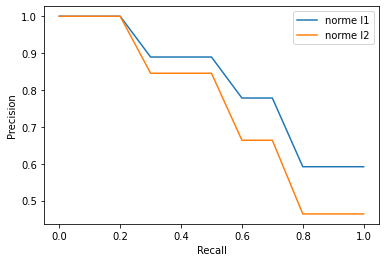

In [13]:
recall_l1,precision_l1=recall_precision(queries_dic,groundtruth,data_hist,"L1",True)
recall_l2,precision_l2=recall_precision(queries_dic,groundtruth,data_hist,"L2",True)
plt.plot(recall_l1,precision_l1,label='norme l1')
plt.plot(recall_l2,precision_l2,label='norme l2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#### Incidence de la taille des bins

###### Affichage de l'évolution du score mAP en fonction du nombre de bins

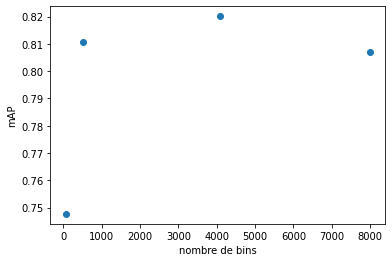

In [19]:
bins_size=[4,8,16,20]
map_hist=[]
for b in bins_size:
    data_hist=histogramms(data_dic,b)
    map_hist.append(mAP(queries_dic,groundtruth,data_hist,"L1",True))

plt.plot([i**3 for i in bins_size],map_hist,'o')
plt.xlabel('nombre de bins')
plt.ylabel('mAP')
plt.show()

###### Affichage des courbes rappel/précision en fonction du nombre de bins

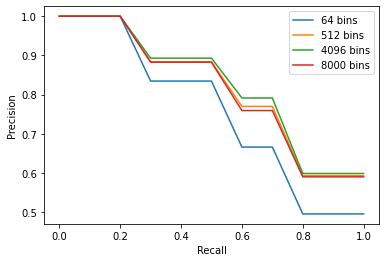

In [32]:
rec_pres=[]
for b in bins_size:

    data_hist=histogramms(data_dic,b)
    rp=recall_precision(queries_dic,groundtruth,data_hist,"L1",True)

    rec_pres.append(rp)
    plt.plot(rec_pres[-1][0],rec_pres[-1][1],label=str(b**3)+ " bins")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


###### Affichage de l'évolution du temps de calcul du requête  en fonction du nombre de bins

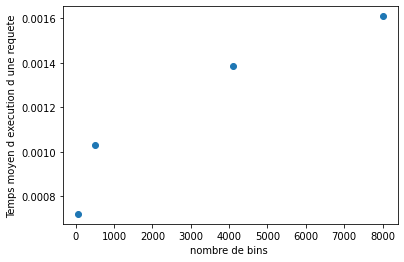

In [20]:
t=[]
for b in bins_size:
    data_hist=histogramms(data_dic,b)
    t1=time.time()
    for q in queries_dic.keys():
       res= moteur_de_recherche_hist(q,data_hist,"L1")
    t2=time.time()
    t.append((t2-t1)/ (len(data_hist)))
plt.plot([i**3 for i in bins_size],t,'o')
plt.xlabel('nombre de bins ')
plt.ylabel('Temps moyen d execution d une requete')

plt.show()

## 2) Recherche avec sac de mots

##### Initialisation des vocabulaires et des decripteurs:

In [4]:
voc_size=["25c","50","75","100","1000"]
voc_size_int=[25,50,75,100,1000]
vocabulaires={}
for v in voc_size:
    vocabulaires[v]=vocab_to_dic(np.load("visual_vocabularies/voc"+v+".npy"))
descripteurs=get_descritpeurs(data_dic)
voc5000=vocab_to_dic(np.load("visual_vocabularies/voc"+"5000"+".npy"))

##### Influence de la norme et de la normalisation :

###### Initialisation des sacs de mots avec 1000 mots:

In [6]:
sdm_l1=all_sac_de_mots(vocabulaires["1000"],descripteurs,1)
sdm_normalise_l1=normalisation(sdm_l1,1)
sdm_pondere_l1=ponderation(sdm_normalise_l1,vocabulaires["1000"])
sdm_final_L1=normalisation(sdm_pondere_l1,1)

sdm_l2=all_sac_de_mots(vocabulaires["1000"],descripteurs,2)
sdm_normalise_l2=normalisation(sdm_l2,2)
sdm_pondere_l2=ponderation(sdm_normalise_l2,vocabulaires["1000"])
sdm_final_L2=normalisation(sdm_pondere_l2,2)


###### Affichage du score mAP en fonction de la norme choisie, pour les sacs de mots normalisés et non normalisés (Taille du vocabulaire: 1000 mots)  :

In [9]:
map_sdm_l2=mAP(queries_dic,groundtruth,sdm_normalise_l2,2)
map_sdm_l1=mAP(queries_dic,groundtruth,sdm_normalise_l1,1)
print("map_l1_normalisé= ",map_sdm_l1,"map_l2_normalisé=",map_sdm_l2)
map_sdm_l2=mAP(queries_dic,groundtruth,sdm_l2,2)
map_sdm_l1=mAP(queries_dic,groundtruth,sdm_l1,1)
print("map_l1_non_normalisé= ",map_sdm_l1,"map_l2_non_normalisé=",map_sdm_l2)

map_l1_normalisé=  0.86254093482541 map_l2_normalisé= 0.7987041112701386
map_l1_non_normalisé=  0.508189190824697 map_l2_non_normalisé= 0.6746320723417735


###### Affichage des courbes rappel précision en fonction de la norme choisie, pour les sacs de mots normalisés et non normalisés (Taille du vocabulaire: 1000 mots) :

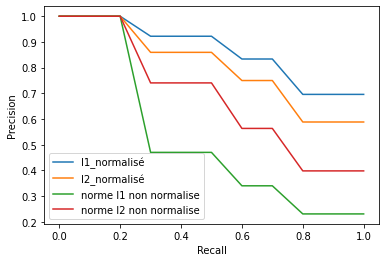

In [10]:
l1=recall_precision(queries_dic,groundtruth,sdm_normalise_l1,1)
l2=recall_precision(queries_dic,groundtruth,sdm_normalise_l2,2)
l3=recall_precision(queries_dic,groundtruth,sdm_l1,1)
l4=recall_precision(queries_dic,groundtruth,sdm_l2,2)
plt.plot(l1[0],l1[1],label='l1_normalisé')
plt.plot(l2[0],l2[1],label='l2_normalisé')
plt.plot(l3[0],l3[1],label='norme l1 non normalise')
plt.plot(l4[0],l4[1],label='norme l2 non normalise')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### Evaluation des performances des pondération avec un petit et un grand vocabulaire :

###### Comparaison des courbes rappel/précision avec un vocabulaire de petite taille(50) et un de plus grande taille (5000)

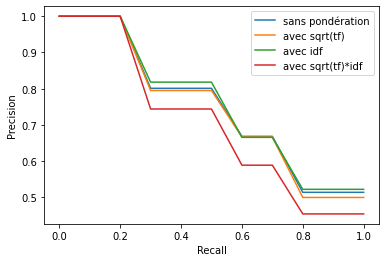

In [17]:
sdm_l1=all_sac_de_mots(vocabulaires["50"],descripteurs,1)
sdm_normalise_l1=normalisation(sdm_l1,1)
sdm_racine=normalisation(sqrt_tf(sdm_normalise_l1),1)
sdm_idf=normalisation(idf(sdm_normalise_l1,vocabulaires["50"]),1)
sdm=normalisation(ponderation(sdm_normalise_l1,vocabulaires["50"]),1)

l1=recall_precision(queries_dic,groundtruth,sdm_normalise_l1,1)
l2=recall_precision(queries_dic,groundtruth,sdm_racine,1)
l3=recall_precision(queries_dic,groundtruth,sdm_idf,1)
l4=recall_precision(queries_dic,groundtruth,sdm,1)
plt.plot(l1[0],l1[1],label='sans pondération')
plt.plot(l2[0],l2[1],label='avec sqrt(tf)')
plt.plot(l3[0],l3[1],label='avec idf')
plt.plot(l4[0],l4[1],label='avec sqrt(tf)*idf')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


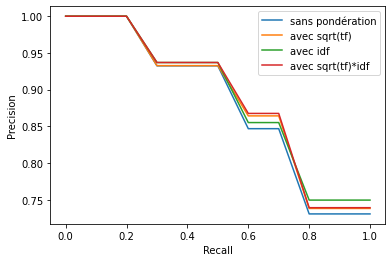

In [21]:
sdm_l1=all_sac_de_mots(voc5000,descripteurs,1)
sdm_normalise_l1=normalisation(sdm_l1,1)
sdm_racine=normalisation(sqrt_tf(sdm_normalise_l1),1)
sdm_idf=normalisation(idf(sdm_normalise_l1,voc5000),1)
sdm=normalisation(ponderation(sdm_normalise_l1,voc5000),1)
l1=recall_precision(queries_dic,groundtruth,sdm_normalise_l1,1)
l2=recall_precision(queries_dic,groundtruth,sdm_racine,1)
l3=recall_precision(queries_dic,groundtruth,sdm_idf,1)
l4=recall_precision(queries_dic,groundtruth,sdm,1)

plt.plot(l1[0],l1[1],label='sans pondération')
plt.plot(l2[0],l2[1],label='avec sqrt(tf)')
plt.plot(l3[0],l3[1],label='avec idf')
plt.plot(l4[0],l4[1],label='avec sqrt(tf)*idf')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

###### Affichage des courbes rappel précision en fonction de la taille du vocabulaire

25c
50
75
100
1000


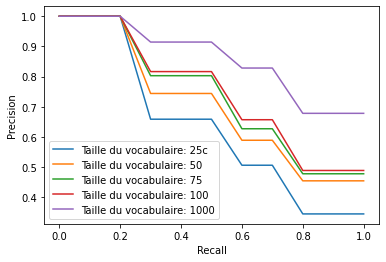

In [11]:
rp=[]
mp=[]
for v in voc_size:
    print(v)
    sdm=all_sac_de_mots(vocabulaires[v],descripteurs,1)
    sdm_normalise=normalisation(sdm,1)
    sdm_pondere=ponderation(sdm_normalise,vocabulaires[v])
    sdm_final=normalisation(sdm_pondere,1)
    rp.append(recall_precision(queries_dic,groundtruth,sdm_final,1))
    mp.append(mAP(queries_dic,groundtruth,sdm_final,1))
    plt.plot(rp[-1][0],rp[-1][1],label="Taille du vocabulaire: "+v)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

###### Affichage de l'évolution du score mAP en fonction de la taille du vocabulaire

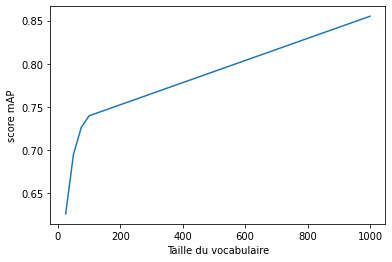

In [13]:
plt.plot(voc_size_int,mp)
plt.xlabel('Taille du vocabulaire')
plt.ylabel('score mAP')
plt.show()

###### Temps de calcul moyen en fonction de la taille du vocabulaire

25c
50
75
100
1000


Text(0, 0.5, 'Temps moyen d execution d une requete')

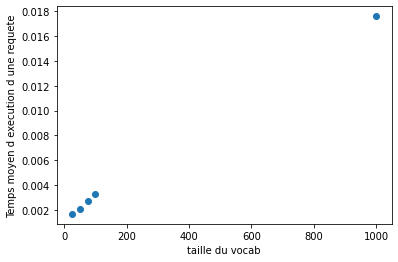

In [5]:
t=[]
for v in vocabulaires.items():
    print(v[0])
    sdm=all_sac_de_mots(v[1],descripteurs,1)
    sdm_normalise=normalisation(sdm,1)
    sdm_pondere=ponderation(sdm_normalise,v[1])
    sdm_final=normalisation(sdm_pondere,1)
    t1=time.time()
    for q in queries_dic.keys():
        res=recherche(sdm,1,q)
    t2=time.time()
    t.append((t2-t1)/ (len(sdm)))
plt.plot(voc_size_int,t,'o')
plt.xlabel('taille du vocab')
plt.ylabel('Temps moyen d execution d une requete')

## 3) Recherche avec index inversé

###### Affichage des courbes rappel précision en fonction de la taille du vocabulaire

25c
50
75
100
1000


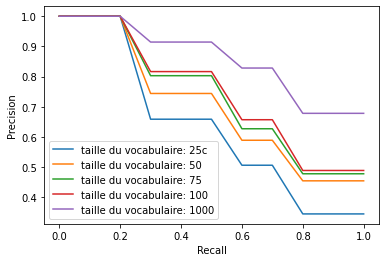

In [13]:
map=[]
rec=[]
pres=[]
for v in voc_size:
    print(v)
    sdm=all_sac_de_mots(vocabulaires[v],descripteurs,1)
    sdm_normalise=normalisation(sdm,1)
    sdm_pondere=ponderation(sdm_normalise,vocabulaires[v])
    sdm_final=normalisation(sdm_pondere,1)
    sdm_inverse=index_inverse(sdm_final,vocabulaires[v])
    tab=[]
    for q in queries_dic.items():
        dic = {}
        res = recherche_inverse(sdm_inverse,q[0],descripteurs,vocabulaires[v],sdm_final,1)
        dic["relevant"] = res
        dic["id"] = q[0]
        tab.append(dic)
    gr = {"groundtruh": tab}
    e = Evaluator(gr, groundtruth)
    rec_pres = e.evaluate_pr_points()
    recall = [i[0] for i in rec_pres]
    precision = [i[1] for i in rec_pres]
    rec.append(recall)
    pres.append(precision)
    map.append(e.evaluate_map())
    plt.plot(rec[-1],pres[-1],label='taille du vocabulaire: '+v)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

###### Affichage de l'évolution du score mAP en fonction de la taille du vocabulaire

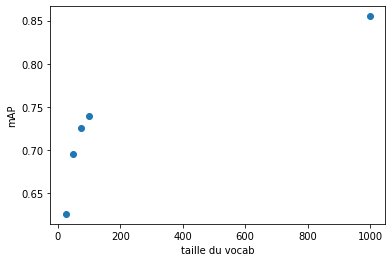

In [14]:
plt.plot(voc_size_int,map,'o')
plt.xlabel('taille du vocab')
plt.ylabel('mAP')
plt.show()

###### Temps de calcul moyen en fonction de la taille du vocabulaire

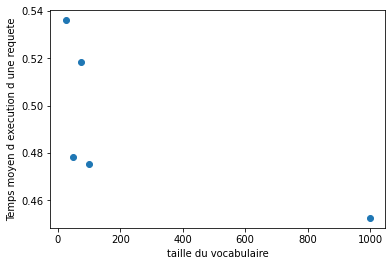

In [17]:
t=[]
for v in voc_size:

    sdm=all_sac_de_mots(vocabulaires[v],descripteurs,1)
    sdm_normalise=normalisation(sdm,1)
    sdm_pondere=ponderation(sdm_normalise,vocabulaires[v])
    sdm_final=normalisation(sdm_pondere,1)
    sdm_inverse=index_inverse(sdm_final,vocabulaires[v])
    t1=time.time()
    for q in queries_dic.keys():
       res= recherche_inverse(sdm_inverse,q,descripteurs,vocabulaires[v],sdm_final,1)
    t2=time.time()
    t.append((t2-t1)/ (len(sdm_inverse)))


plt.plot(voc_size_int,t,'o')
plt.xlabel('taille du vocabulaire')
plt.ylabel('Temps moyen d execution d une requete')
plt.show()


## 4) Recherche avec la méthode VLAD

##### Incidence de l'analyse en composantes principales et du nombre de dimensions

###### Initialisation de l'index VLAD

##### Initialisation des vocabulaires :

In [22]:
voc_size=["25c","50","75","100"]
voc_size_int=[25,50,75,100]
vocabulaires={}
for v in voc_size:
    vocabulaires[v]=vocab_to_dic(np.load("visual_vocabularies/voc"+v+".npy"))

In [23]:
index=index_VLAD(descripteurs,vocabulaires["25c"],2)
index_sans_acp=array_to_dic(index)
recall,precision=recall_precision(queries_dic,groundtruth,index_sans_acp,2)

###### Affichage des courbes de rappel/précision en fonction du nombre de dimensions

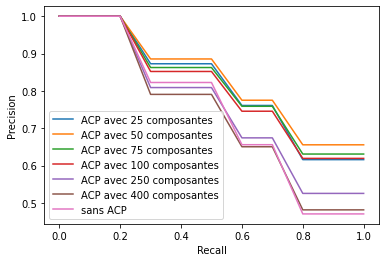

In [24]:
val_acp=[25,50,75,100,250,400]
map=[]
rec_pres=[]
for v in val_acp:
    ind=acp(index,v)
    map.append(mAP(queries_dic,groundtruth,ind,2))
    rec_pres.append(recall_precision(queries_dic,groundtruth,ind,2))
    plt.plot(rec_pres[-1][0],rec_pres[-1][1],label="ACP avec "+str(v)+ " composantes")
plt.plot(recall,precision,label="sans ACP")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

###### Affichage de l'évolution du score map en fonction du nombre de dimensions

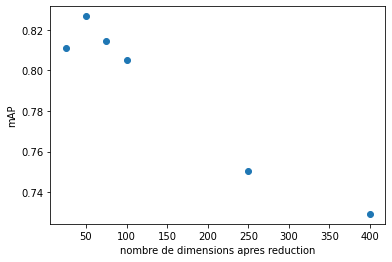

In [43]:
plt.plot(val_acp,map,'o')
plt.xlabel('nombre de dimensions apres reduction')
plt.ylabel('mAP')
plt.show()

###### Temps de calcul moyen en fonction du nombre de composantes

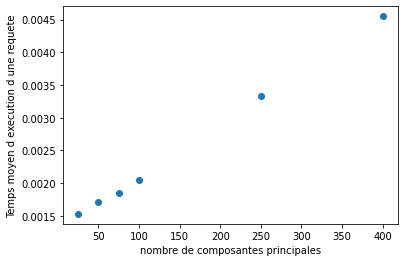

In [25]:
index=index_VLAD(descripteurs,vocabulaires["25c"],2)
t=[]
for v in val_acp:
    ind=acp(index,v)
    t1=time.time()
    for q in queries_dic.keys():
       res= recherche_VLAD(ind,q,2)
    t2=time.time()
    t.append((t2-t1)/ (len(ind)))
plt.plot(val_acp,t,'o')
plt.xlabel('nombre de composantes principales')
plt.ylabel('Temps moyen d execution d une requete')
plt.show()

##### Incidence de la taille du vocabulaire

###### Affichage des courbes de rappel/précision en fonction de la taille du vocabulaire :

25c
50
75
100


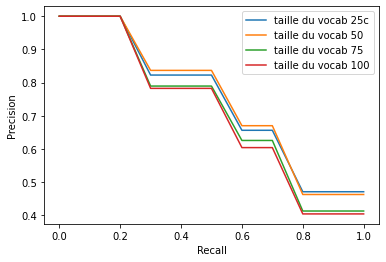

In [7]:
rec_pres_vlad=[]
map_vlad=[]
for v in vocabulaires.items():
    print(v[0])
    index=array_to_dic(index_VLAD(descripteurs,v[1],2))
    rec_pres_vlad.append(recall_precision(queries_dic,groundtruth,index,2))
    map_vlad.append(mAP(queries_dic,groundtruth,index,2))
    plt.plot(rec_pres_vlad[-1][0],rec_pres_vlad[-1][1],label="taille du vocab " +v[0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

###### Affichage de l'évolution du score map en fonction de la taille du vocabulaire

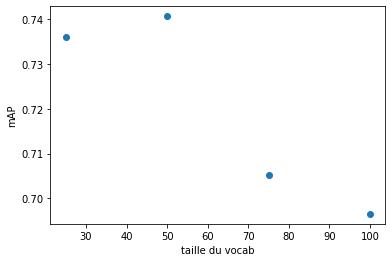

In [13]:
plt.plot(voc_size_int,map_vlad,'o')
plt.xlabel('taille du vocab')
plt.ylabel('mAP')
plt.show()

###### Temps de calcul moyen en fonction de la taille du vocabulaire

25c
50
75
100


Text(0, 0.5, 'Temps moyen d execution d une requete')

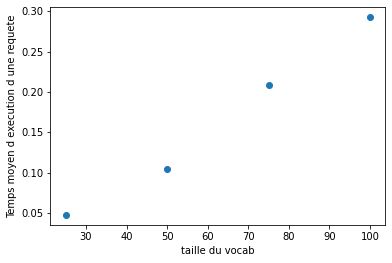

In [25]:
t=[]
for v in vocabulaires.items():
    print(v[0])
    index=array_to_dic(index_VLAD(descripteurs,v[1],2))
    t1=time.time()
    for q in queries_dic.keys():
       res= recherche_VLAD(index,q,2)
    t2=time.time()
    t.append((t2-t1)/ (len(index)))
plt.plot(voc_size_int,t,'o')
plt.xlabel('taille du vocab')
plt.ylabel('Temps moyen d execution d une requete')
